In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

In this notebook I would like the answer the question-
“what sorts of people were more likely to survive?”
using some classification models that predicts which passengers survived the Titanic shipwreck.

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# **Importing the datasets**

## **Train data**

In [3]:
train_data = pd.read_csv('/kaggle/input/titanic/train.csv')
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


The train data contain information about 891 passengers (rows) and 12 columns.

In [4]:
train_data.shape

(891, 12)

## **Test data**

In [5]:
test_data = pd.read_csv('/kaggle/input/titanic/test.csv')
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


The test data contain information about 418 passengers (rows) and 11 columns.

In [6]:
test_data.shape

(418, 11)

# **Features Engineering & Data Analysis**

#### For Features Engineering let's combine the train set and the test set.

In [7]:
all_data = train_data.append(test_data)

In [8]:
all_data.shape

(1309, 12)

#### **The type of each column in the data frame:**

In [9]:
all_data.dtypes

PassengerId      int64
Survived       float64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

* #### **Checking whether there are missing data**

In [10]:
all_data.columns[all_data.isna().any()].tolist()

['Survived', 'Age', 'Fare', 'Cabin', 'Embarked']

It's obvious why there are missing values in the Survived column...

I can't see how the information about the Cabin can help, so I won't fill up the empty cells.

For the rest columns with missing values, let's do some manipulations to fill up the empty cells.

* #### **Age**
To imputing the age more precisely, let's define a new temp column- 'Title' (the title of each passenger). 

In [11]:
all_data['Title'] = all_data['Name']

# Cleaning name and extracting Title
for name_string in all_data['Name']:
    all_data['Title'] = all_data['Name'].str.extract('([A-Za-z]+)\.', expand=True)

all_data.Title.unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'Countess',
       'Jonkheer', 'Dona'], dtype=object)

In [12]:
# Replacing rare titles with more common ones
mapping = {'Mlle': 'Miss', 'Major': 'Mr', 'Col': 'Mr', 'Sir': 'Mr', 'Don': 'Mr', 'Mme': 'Miss',
          'Jonkheer': 'Mr', 'Lady': 'Mrs', 'Capt': 'Mr', 'Countess': 'Mrs', 'Ms': 'Miss', 'Dona': 'Mrs'}

all_data.replace({'Title': mapping}, inplace=True)
titles = ['Dr', 'Master', 'Miss', 'Mr', 'Mrs', 'Rev']

for title in titles:
    age_to_impute = all_data.groupby('Title')['Age'].median()[titles.index(title)]
    all_data.loc[(all_data['Age'].isnull()) & (all_data['Title'] == title), 'Age'] = age_to_impute
    
# Substituting Age values in TRAIN_DF and TEST_DF:
train_data['Age'] = all_data['Age'][:891]
test_data['Age'] = all_data['Age'][891:]

# Dropping Title feature
all_data.drop('Title', axis = 1, inplace = True)

We will create a new column, AgeGroup, that will contain the age groups of the passengers according the following partition:
- Infant: 0-3
- Kid: 4-12
- Teen: 13-19
- Adult: 20-110

After that, we will encode this column to a new one - AgeGroup_code.

In [13]:
bins= [0,4,13,20,110]
labels = ['Infant','Kid','Teen','Adult']
all_data['AgeGroup'] = pd.cut(train_data['Age'], bins=bins, labels=labels, right=False)

label = LabelEncoder()

all_data['AgeGroup_code'] = label.fit_transform(all_data['AgeGroup'])

train_data['AgeGroup_code'] = all_data['AgeGroup_code'][:891]
test_data['AgeGroup_code'] = all_data['AgeGroup_code'][891:]

In [14]:
all_data[['AgeGroup', 'AgeGroup_code']].head(10)

,AgeGroup,AgeGroup_code
0,Adult,0
1,Adult,0
2,Adult,0
3,Adult,0
4,Adult,0
5,Adult,0
6,Adult,0
7,Infant,1
8,Adult,0
9,Teen,3


- 0 : Adult
- 1 : Infant
- 2 : Kid
- 3 : Teen

* #### **Embarked**
Let's fill up the missing values cells in the Embarked column with the most common value.

In [15]:
print('the most common value in the Embarked column: ', all_data.Embarked.value_counts().idxmax())

the most common value in the Embarked column:  S


In [16]:
all_data.Embarked.fillna('S', inplace = True)

* #### **Fare**
Filling up the missing values with the median of the Fare column

In [17]:
all_data.Fare.fillna(all_data.Fare.median(), inplace = True)

Encoding the Fare column into a new column - FareBins_code :

In [18]:
all_data['FareBins'] = pd.qcut(all_data.Fare, 5)
print(all_data['FareBins'].unique())
label = LabelEncoder()

all_data['FareBins_code'] = label.fit_transform(all_data['FareBins'])

train_data['FareBins_code'] = all_data['FareBins_code'][:891]
test_data['FareBins_code'] = all_data['FareBins_code'][891:]

[(-0.001, 7.854], (41.579, 512.329], (7.854, 10.5], (10.5, 21.558], (21.558, 41.579]]
Categories (5, interval[float64, right]): [(-0.001, 7.854] < (7.854, 10.5] < (10.5, 21.558] < (21.558, 41.579] < (41.579, 512.329]]


In [19]:
all_data[['FareBins','FareBins_code']].head(10)

,FareBins,FareBins_code
0,"(-0.001, 7.854]",0
1,"(41.579, 512.329]",4
2,"(7.854, 10.5]",1
3,"(41.579, 512.329]",4
4,"(7.854, 10.5]",1
5,"(7.854, 10.5]",1
6,"(41.579, 512.329]",4
7,"(10.5, 21.558]",2
8,"(10.5, 21.558]",2
9,"(21.558, 41.579]",3


- 0 : (-0.001, 7.854]
- 1 : (7.854, 10.5]
- 2 : (10.5, 21.558]
- 3 : (21.558, 41.579]
- 4 : (41.579, 512.329]

* #### **Sex**
We will encode the Sex column into a new column- Sex_cat, where 0 = female and 1 = male.

In [20]:
all_data["Sex"] = all_data["Sex"].astype('category')
all_data["Sex_cat"] = all_data["Sex"].cat.codes

train_data['Sex_cat'] = all_data['Sex_cat'][:891]
test_data['Sex_cat'] = all_data['Sex_cat'][891:]

In [21]:
all_data[['Sex', 'Sex_cat']].head()

,Sex,Sex_cat
0,male,1
1,female,0
2,female,0
3,female,0
4,male,1


* male : 1
* female : 0 

* #### **Adding Family_Size**

In [22]:
all_data['Family_Size'] = all_data['SibSp'] + all_data['Parch']

# Substituting the values in train_data and test_data:
train_data['Family_Size'] = all_data['Family_Size'][:891]
test_data['Family_Size'] = all_data['Family_Size'][891:]

* #### **Adding Family_Survival**
Grouping families and people with the same tickets together and researches the info.

In [23]:
all_data['Last_Name'] = all_data['Name'].apply(lambda x: str.split(x, ",")[0])

In [24]:
DEFAULT_SURVIVAL_VALUE = 0.5
all_data['Family_Survival'] = DEFAULT_SURVIVAL_VALUE

for grp, grp_df in all_data[['Survived','Name', 'Last_Name', 'Fare', 'Ticket', 'PassengerId',
                           'SibSp', 'Parch', 'Age', 'Cabin']].groupby(['Last_Name', 'Fare']):
    
    if len(grp_df) != 1: # A Family group is found.
        
        for ind, row in grp_df.iterrows():
            surv_max = grp_df.drop(ind)['Survived'].max()
            surv_min = grp_df.drop(ind)['Survived'].min()
            passID = row['PassengerId']
            
            if surv_max == 1.0:
                all_data.loc[all_data.PassengerId == passID, 'Family_Survival'] = 1
            elif surv_min == 0.0:
                all_data.loc[all_data.PassengerId == passID, 'Family_Survival'] = 0

print("Number of passengers with family survival information:", 
      all_data.loc[all_data['Family_Survival'] != 0.5].shape[0])

Number of passengers with family survival information: 420


In [25]:
for grp, grp_df in all_data.groupby('Ticket'):
    if len(grp_df) != 1:
        
        for ind, row in grp_df.iterrows():
            if (row['Family_Survival'] == 0) | (row['Family_Survival'] == 0.5):
                surv_max = grp_df.drop(ind)['Survived'].max()
                surv_min = grp_df.drop(ind)['Survived'].min()
                passID = row['PassengerId']

                if surv_max == 1.0:
                    all_data.loc[all_data.PassengerId == passID, 'Family_Survival'] = 1
                elif surv_min == 0.0:
                    all_data.loc[all_data.PassengerId == passID, 'Family_Survival'] = 0
print("Number of passenger with family/group survival information: " ,
      (all_data[all_data['Family_Survival']!=0.5].shape[0]))

Number of passenger with family/group survival information:  546


In [26]:
# # Family_Survival in TRAIN_DATA and TEST_DATA:
train_data['Family_Survival'] = all_data['Family_Survival'][:891]
test_data['Family_Survival'] = all_data['Family_Survival'][891:]

* #### **Cleaning Data**

In [27]:
all_data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'AgeGroup',
       'AgeGroup_code', 'FareBins', 'FareBins_code', 'Sex_cat', 'Family_Size',
       'Last_Name', 'Family_Survival'],
      dtype='object')

In [28]:
train_data.drop(['PassengerId','Name', 'Sex', 'Age', 'SibSp',
                 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'], axis = 1, inplace = True)

test_data.drop(['PassengerId','Name', 'Sex', 'Age', 'SibSp',
                 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'], axis = 1, inplace = True)

In [29]:
print("Train data column names: ", train_data.columns)
print("\nTest data column names: ", test_data.columns)

Train data column names:  Index(['Survived', 'Pclass', 'AgeGroup_code', 'FareBins_code', 'Sex_cat',
       'Family_Size', 'Family_Survival'],
      dtype='object')

Test data column names:  Index(['Pclass', 'AgeGroup_code', 'FareBins_code', 'Sex_cat', 'Family_Size',
       'Family_Survival'],
      dtype='object')


#### From now on we will continue to work with the training set (train_data) and not with all the data

### **Statistical information and visualization:**

In [30]:
train_data.describe(include='all')

,Survived,Pclass,AgeGroup_code,FareBins_code,Sex_cat,Family_Size,Family_Survival
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,0.450056,1.985410,0.647587,0.904602,0.519641
std,0.486592,0.836071,0.992402,1.411355,0.477990,1.613459,0.323961
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,1.000000,0.000000,0.000000,0.500000
50%,0.000000,3.000000,0.000000,2.000000,1.000000,0.000000,0.500000
75%,1.000000,3.000000,0.000000,3.000000,1.000000,1.000000,0.500000
max,1.000000,3.000000,3.000000,4.000000,1.000000,10.000000,1.000000


Text(0.5, 0, 'Fare Range')

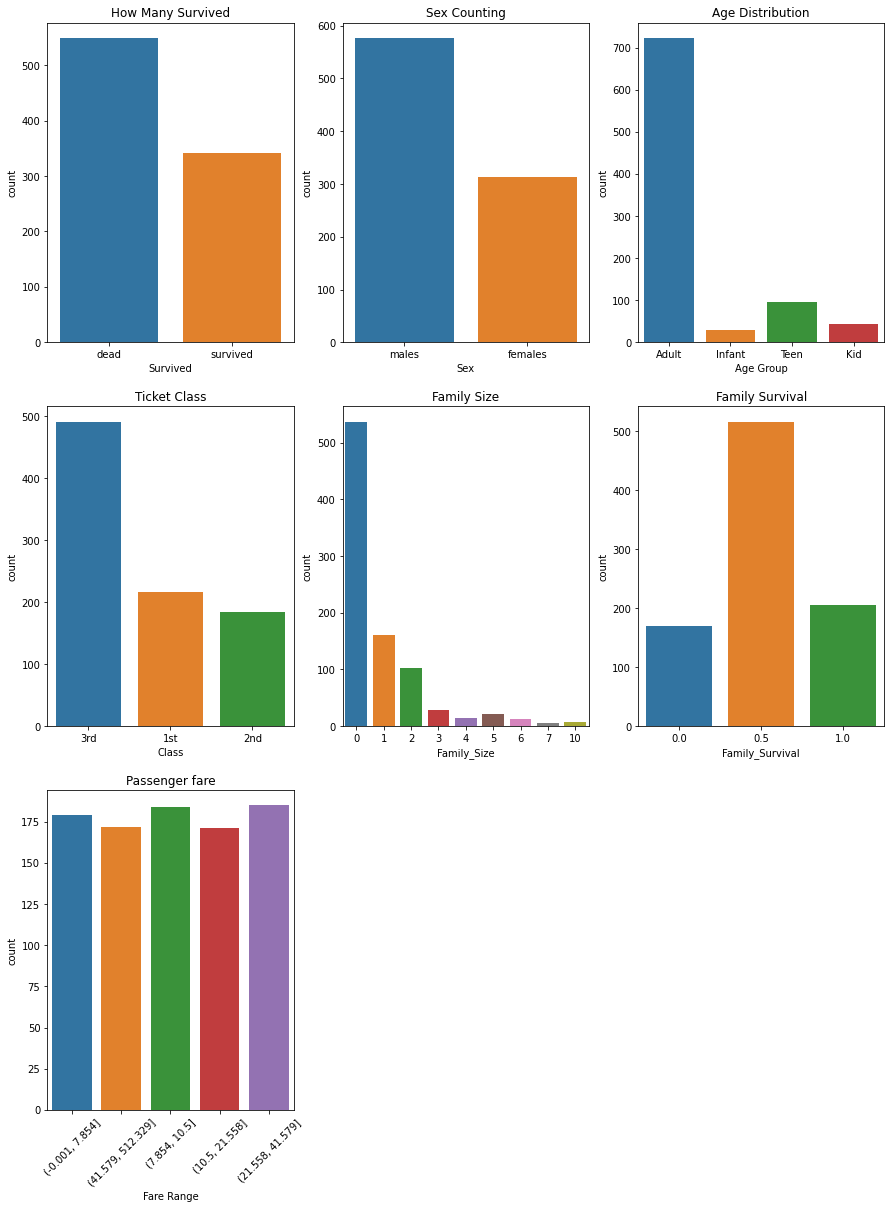

In [31]:
plt.figure(figsize = (15,20))

plt.subplot(3, 3, 1)
sns.countplot(x = 'Survived', data = train_data.replace({'Survived':{0:'dead', 1:'survived'}}))
plt.title("How Many Survived")

plt.subplot(3, 3, 2)
sns.countplot(x = "Sex_cat", data = train_data.replace({'Sex_cat':{0:'females', 1:'males'}}))
plt.title("Sex Counting")
plt.xlabel("Sex")

plt.subplot(3, 3, 3)
sns.countplot(x = "AgeGroup_code", data = train_data.replace({'AgeGroup_code':{0:'Adult',1:'Infant',2:'Kid',3:'Teen'}}))
plt.title("Age Distribution")
plt.xlabel("Age Group")

plt.subplot(3, 3, 4)
sns.countplot(x = 'Pclass', data = train_data.replace({'Pclass':{1:'1st', 2:'2nd', 3:'3rd'}}))
plt.title('Ticket Class')
plt.xlabel("Class")

plt.subplot(3, 3, 5)
sns.countplot(x = 'Family_Size', data = train_data)
plt.title("Family Size")

plt.subplot(3, 3, 6)
sns.countplot(x = 'Family_Survival', data = train_data)
plt.title('Family Survival')

plt.subplot(3, 3, 7)
sns.countplot(x = 'FareBins_code', data = train_data.replace({'FareBins_code':{0:'(-0.001, 7.854]',
                                                                              1:'(7.854, 10.5]',
                                                                              2:'(10.5, 21.558]',
                                                                              3:'(21.558, 41.579]',
                                                                              4:'(41.579, 512.329]'}}))
plt.title('Passenger fare')
plt.xticks(rotation = 45)
plt.xlabel("Fare Range")

 #### According to the descriptive statistics table and the plots above-

**Survived:**
- Most of the passengers didn't survived (as we already know...), the mean = 0.3838 and the median = 0.

**Ticket Class (Pclass):**
- The mean = 2.3 and the median = 3, indicates that most tickets are for third class.

**Age/AgeGroup_code**
- The average AgeGroup_code is 0.45 and the median is 0, with a std of ~0.99. Most of the passengers are adults.

**Fare/FareBins_code**
- It seems that most of the passengers paids for the trip between 7.854 to 10.5 and between 21.558 to 41.579.

**Sex**
- Most of passengers are males.

**Family Size:**
- Most of the passengers came alone (mean = 0.9, std = 1.6).

**Family Survival:**
- There is no substantial evidence that being with family or being part of a group changes the chance of survival.

#### We want to evaluate which features are affecting the chance to survive.
#### Accordingly, let's visually examine the connection.

**Survived ~ Sex**

% of men who survived: 0.18890814558058924
% of women who survived: 0.7420382165605095


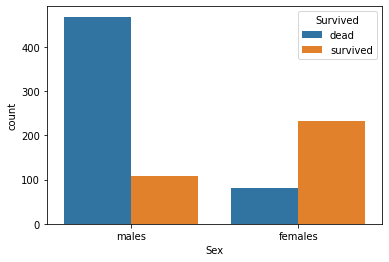

In [32]:
women = train_data.loc[train_data.Sex_cat == 0]['Survived']
rate_women = sum(women) / len(women)

men = train_data.loc[train_data.Sex_cat == 1]['Survived']
rate_men = sum(men) / len(men)

print("% of men who survived:", rate_men)
print("% of women who survived:", rate_women)

sns.countplot(x = 'Sex_cat', data = train_data.replace({'Sex_cat':{0:'females', 1:'males'}}), hue = 'Survived')
plt.xlabel("Sex")
plt.legend(labels = ['dead', 'survived'], title = 'Survived')

**Survived ~ Ticket Class (Pclass)**

% of class 1 who survived: 0.6296296296296297
% of class 2 who survived: 0.47282608695652173
% of class 3 who survived: 0.24236252545824846


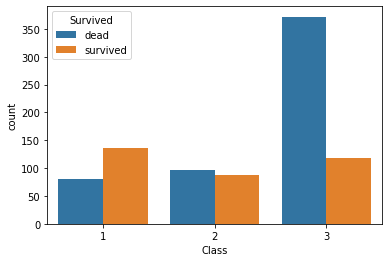

In [33]:
class1 = train_data.loc[train_data.Pclass == 1]['Survived']
rate_class1 = sum(class1) / len(class1)

class2 = train_data.loc[train_data.Pclass == 2]['Survived']
rate_class2 = sum(class2) / len(class2)

class3 = train_data.loc[train_data.Pclass == 3]['Survived']
rate_class3 = sum(class3) / len(class3)

print("% of class 1 who survived:", rate_class1)
print("% of class 2 who survived:", rate_class2)
print("% of class 3 who survived:", rate_class3)

sns.countplot(x = 'Pclass', data = train_data, hue = 'Survived')
plt.xlabel("Class")
plt.legend(labels = ['dead', 'survived'], title = 'Survived')

**Survived ~ Family Size**

% of passengers who have  1  of family members aboard the Titanic that survived: 0.5527950310559007
% of passengers who have  0  of family members aboard the Titanic that survived: 0.30353817504655495
% of passengers who have  4  of family members aboard the Titanic that survived: 0.2
% of passengers who have  2  of family members aboard the Titanic that survived: 0.5784313725490197
% of passengers who have  6  of family members aboard the Titanic that survived: 0.3333333333333333
% of passengers who have  5  of family members aboard the Titanic that survived: 0.13636363636363635
% of passengers who have  3  of family members aboard the Titanic that survived: 0.7241379310344828
% of passengers who have  7  of family members aboard the Titanic that survived: 0.0
% of passengers who have  10  of family members aboard the Titanic that survived: 0.0


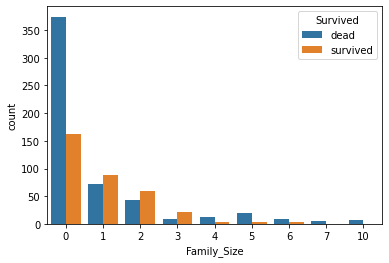

In [34]:
for i in train_data.Family_Size.unique():
    temp_survived = train_data.loc[train_data.Family_Size == i]['Survived']
    rate = sum(temp_survived) / len(temp_survived)
    print("% of passengers who have ", i, " of family members aboard the Titanic that survived:", rate)
    
sns.countplot(x = 'Family_Size', data = train_data, hue = 'Survived')
plt.legend(labels = ['dead', 'survived'], title = 'Survived', loc='upper right')

**Survived ~ Fare**

% of passengers who paid in a range  (-0.001, 7.854]  for a ticket that survived: 0.21787709497206703
% of passengers who paid in a range  (41.579, 512.329]  for a ticket that survived: 0.6453488372093024
% of passengers who paid in a range  (7.854, 10.5]  for a ticket that survived: 0.20108695652173914
% of passengers who paid in a range  (10.5, 21.558]  for a ticket that survived: 0.4269005847953216
% of passengers who paid in a range  (21.558, 41.579]  for a ticket that survived: 0.44324324324324327


(array([0, 1, 2, 3, 4]),
 [Text(0, 0, '(-0.001, 7.854]'),
  Text(1, 0, '(41.579, 512.329]'),
  Text(2, 0, '(7.854, 10.5]'),
  Text(3, 0, '(10.5, 21.558]'),
  Text(4, 0, '(21.558, 41.579]')])

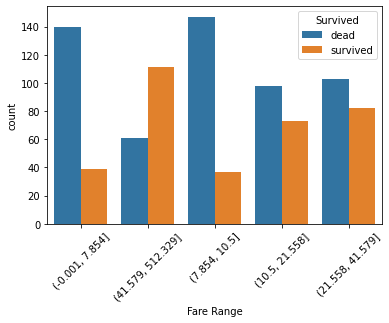

In [35]:
temp_train = train_data.replace({'FareBins_code':{0:'(-0.001, 7.854]',1:'(7.854, 10.5]',
                                                  2:'(10.5, 21.558]',3:'(21.558, 41.579]',4:'(41.579, 512.329]'}})
for i in temp_train.FareBins_code.unique():
    temp_survived = temp_train.loc[temp_train.FareBins_code == i]['Survived']
    rate = sum(temp_survived) / len(temp_survived)
    print("% of passengers who paid in a range ", i, " for a ticket that survived:", rate)
    

sns.countplot(x = 'FareBins_code', data = temp_train, hue = 'Survived')
plt.xlabel("Fare Range")
plt.legend(labels = ['dead', 'survived'], title = 'Survived', loc='upper right')
plt.xticks(rotation = 45)

**Survived ~ Age**

% of Adults that survived: 0.36099585062240663
% of Infants that survived: 0.6666666666666666
% of Teens that survived: 0.4105263157894737
% of Kids that survived: 0.5116279069767442


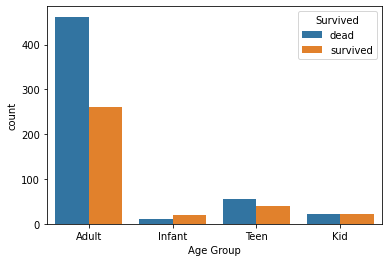

In [36]:
temp_train = train_data.replace({'AgeGroup_code':{0:'Adult',1:'Infant',2:'Kid',3:'Teen'}})
for i in temp_train.AgeGroup_code.unique():
    temp_survived = temp_train.loc[temp_train.AgeGroup_code == i]['Survived']
    rate = sum(temp_survived) / len(temp_survived)
    print("% of", i + 's', "that survived:", rate)

sns.countplot(x = 'AgeGroup_code', data = temp_train, hue = 'Survived')
plt.xlabel("Age Group")
plt.legend(labels = ['dead', 'survived'], title = 'Survived')

###### The features- PassengerId, Name, Number of Ticket, Cabin, Embarked and Fare, are not affecting in any way the chance to survive or not.

# **Model Building**

### Data Preparation
Before using the classification models, let's prepered our data:

In [37]:
X = train_data.loc[:, train_data.columns != "Survived"]
y = train_data["Survived"].values

The feature matrix, X:

In [38]:
X

,Pclass,AgeGroup_code,FareBins_code,Sex_cat,Family_Size,Family_Survival
0,3,0,0,1,1,0.5
1,1,0,4,0,1,0.5
2,3,0,1,0,0,0.5
3,1,0,4,0,1,0.0
4,3,0,1,1,0,0.5
...,...,...,...,...,...,...
886,2,0,2,1,0,0.5
887,1,3,3,0,0,0.5
888,3,0,3,0,3,0.0
889,1,0,3,1,0,0.5


The target column, y:

In [39]:
y[:5]

array([0, 1, 1, 1, 0])

#### Splitting the dataset into the Training set and Test set

In [40]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

In [41]:
X_test

,Pclass,AgeGroup_code,FareBins_code,Sex_cat,Family_Size,Family_Survival
495,3,0,2,1,0,0.0
648,3,0,0,1,0,0.5
278,3,2,3,1,5,0.0
31,1,0,4,0,1,1.0
255,3,0,2,0,2,0.5
...,...,...,...,...,...,...
167,3,0,3,0,5,0.0
306,1,0,4,0,0,1.0
379,3,3,0,1,0,0.5
742,1,0,4,0,4,1.0


#### Feature Scaling

In [42]:
# feature scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

## **Feature and Model Selection**

In [43]:
from sklearn.model_selection import cross_val_score, GridSearchCV, RepeatedStratifiedKFold, RandomizedSearchCV
#cross_val_predict, KFold, 
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFECV

In [44]:
# some experient....
# here we use Decision Tree as estimator in the RFECV
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.ensemble import RandomForestClassifier
# rfe = RFECV(estimator=LogisticRegression(), cv = 10)
# rfe = rfe.fit(X_train,y_train)
# print("Feature ranking: ", rfe.ranking_)

# # extracting the selected features.  get_support() function helps us to get those features names. 
# mask = rfe.get_support()
# features = X.columns
# best_features = features[mask]
 
# print("All features: ", X.shape[1])
# print(features)

# print("Selected best: ", best_features.shape[0])
# print(features[mask])

Let's run RFECV with different estimators to select features. Additionally, let's run some classification models, to get an intuition about which estimator and classification algorithm will give us the best results.

After we chose the estimator and the model, we can check which features are selected and use GridSearchCV to find the best hyperparameters for the chosen model.

In [45]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

In [46]:
# get a list of models to evaluate
def get_models(modelc):
    models = dict()
    # lr
    rfe = RFECV(estimator=LogisticRegression())
    model = modelc
    models['lr'] = Pipeline(steps=[('s',rfe),('m',model)])
    # perceptron
    rfe = RFECV(estimator=Perceptron())
    model = modelc
    models['per'] = Pipeline(steps=[('s',rfe),('m',model)])
    # cart
    rfe = RFECV(estimator=DecisionTreeClassifier())
    model = modelc
    models['cart'] = Pipeline(steps=[('s',rfe),('m',model)])
    # rf
    rfe = RFECV(estimator=RandomForestClassifier())
    model = modelc
    models['rf'] = Pipeline(steps=[('s',rfe),('m',model)])
    # gbm
    rfe = RFECV(estimator=GradientBoostingClassifier())
    model = modelc
    models['gbm'] = Pipeline(steps=[('s',rfe),('m',model)])
    # svm
    rfe = RFECV(estimator=SVC(kernel='linear'))
    model = modelc
    models['svm'] = Pipeline(steps=[('s',rfe),('m',model)])
    return models

# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    return scores

In [47]:
models_dict = {'LR': LogisticRegression(random_state=0),
               'SVM': SVC(kernel='linear', random_state=0),
               'RF': RandomForestClassifier(),
               'KNN': KNeighborsClassifier(),
               'NB': GaussianNB()}

In [48]:
# get the models to evaluate
for i in models_dict.keys():
    print('\n'+i+'\n')
    models = get_models(models_dict[i])
    # evaluate the models and store results
    results, names = list(), list()
    for name, model in models.items():
        scores = evaluate_model(model, X_train, y_train)
        results.append(scores)
        names.append(name)
        print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))


LR

>lr 0.827 (0.034)
>per 0.809 (0.036)
>cart 0.833 (0.037)
>rf 0.824 (0.035)
>gbm 0.833 (0.038)
>svm 0.813 (0.042)

SVM

>lr 0.797 (0.046)
>per 0.800 (0.037)
>cart 0.789 (0.043)
>rf 0.811 (0.041)
>gbm 0.791 (0.038)
>svm 0.808 (0.047)

RF

>lr 0.823 (0.047)
>per 0.812 (0.051)
>cart 0.834 (0.043)
>rf 0.824 (0.043)
>gbm 0.843 (0.041)
>svm 0.821 (0.050)

KNN

>lr 0.812 (0.050)
>per 0.798 (0.049)
>cart 0.829 (0.039)
>rf 0.825 (0.046)
>gbm 0.825 (0.047)
>svm 0.803 (0.067)

NB

>lr 0.795 (0.042)
>per 0.786 (0.042)
>cart 0.791 (0.049)
>rf 0.789 (0.048)
>gbm 0.787 (0.040)
>svm 0.800 (0.039)


O.K, let's continue with the three models with the highest accuracy mean score-
- Random Forest + Gradient Boosting Classifier as estimator in the RFECV (accuracy mean score = 0.842, std = 0.044).
- K-NN + Decision Tree Classifier as estimator in the RFECV (accuracy mean score = 0.83, std = 0.040).
- Logistic Regression + Gradient Boosting Classifier as estimator in the RFECV (accuracy mean score = 0.834, std = 0.038).


## **Random Forest**
The feature that were selected:

In [49]:
rf_rfe = RFECV(estimator=GradientBoostingClassifier())
rf_pipe = Pipeline(steps=[('s',rf_rfe),('m',RandomForestClassifier())])

X_new_rf = rf_rfe.fit_transform(X_train, y_train)
print("Feature ranking: ", rf_rfe.ranking_)

rf_mask = rf_rfe.get_support()
features = X.columns
best_features = features[rf_mask]

# print("All features: ", x.shape[1])
# print(features)

print("Selected best: ", best_features.shape[0])
print(features[rf_mask])

Feature ranking:  [1 1 2 1 3 1]
Selected best:  4
Index(['Pclass', 'AgeGroup_code', 'Sex_cat', 'Family_Survival'], dtype='object')


In [50]:
# X_test[:,rf_mask]

In [51]:
# X_train[:,rf_mask]

Evaluate the model

In [52]:
# evaluate model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(rf_pipe, X_new_rf, y_train, scoring='accuracy', cv=cv, error_score='raise')
# report performance
print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

Accuracy: 0.851 (0.038)


Find the best hyperparameters using RandomizedSearchCV

In [53]:
# Criterion
criterion = ['gini', 'entropy']
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
rf_random_grid = {'m__criterion': criterion,
               'm__n_estimators': n_estimators,
               'm__max_features': max_features,
               'm__max_depth': max_depth,
               'm__min_samples_split': min_samples_split,
               'm__min_samples_leaf': min_samples_leaf,
               'm__bootstrap': bootstrap}

In [54]:
#run very slow
rf_random_search = RandomizedSearchCV(rf_pipe,
                           param_distributions = rf_random_grid,
                           scoring = 'accuracy',
                           cv = cv,
                           random_state = 0)
rf_random_search.fit(X_new_rf, y_train)
best_accuracy = rf_random_search.best_score_
best_parameters = rf_random_search.best_params_
print("Best Accuracy: {:.2f} %".format(best_accuracy*100))
print("Best Parameters:", best_parameters)

Best Accuracy: 85.33 %
Best Parameters: {'m__n_estimators': 1100, 'm__min_samples_split': 10, 'm__min_samples_leaf': 4, 'm__max_features': 'sqrt', 'm__max_depth': 50, 'm__criterion': 'gini', 'm__bootstrap': False}


The out put from the cell above (RandomizedSearchCV):

Best Accuracy: 85.33 %

Best Parameters: {'m__n_estimators': 1100, 'm__min_samples_split': 10, 'm__min_samples_leaf': 4, 'm__max_features': 'auto', 'm__max_depth': 80, 'm__criterion': 'gini', 'm__bootstrap': True}

In [55]:
# '''rf_clf = RandomForestClassifier(n_estimators=1000, criterion='entropy')
# rf_clf.fit(X_new, y_train)
# y_pred = rf_clf.predict(X_test[:,mask])
# cm = confusion_matrix(y_test, y_pred)
# print(cm)
# accuracy_score(y_test, y_pred)'''

In [56]:
# X_train[:,[0,1,2,4]]

In [57]:
# X_new

Predict the test set

In [58]:
best_rf_pipe = rf_random_search.best_estimator_
best_rf_pipe

Pipeline(steps=[('s', RFECV(estimator=GradientBoostingClassifier())),
                ('m',
                 RandomForestClassifier(bootstrap=False, max_depth=50,
                                        max_features='sqrt', min_samples_leaf=4,
                                        min_samples_split=10,
                                        n_estimators=1100))])

In [59]:
best_rf_pipe.score(X_test[:,rf_mask], y_test)

0.8251121076233184

In [60]:
# The next step:
rf_pred = best_rf_pipe.predict(X_test[:,rf_mask])
cm = confusion_matrix(y_test, rf_pred)
print(cm)
accuracy_score(y_test, rf_pred)


[[126  13]
 [ 26  58]]


0.8251121076233184

## **K-NN**

In [61]:
knn_rfe = RFECV(estimator=DecisionTreeClassifier())
knn_pipe = Pipeline(steps=[('s',knn_rfe),('m',KNeighborsClassifier())])

X_new_knn = knn_rfe.fit_transform(X_train, y_train)
print("Feature ranking: ", knn_rfe.ranking_)

knn_mask = knn_rfe.get_support()
features = X.columns
best_features = features[knn_mask]

# print("All features: ", x.shape[1])
# print(features)

print("Selected best: ", best_features.shape[0])
print(features[knn_mask])

Feature ranking:  [1 1 2 1 3 1]
Selected best:  4
Index(['Pclass', 'AgeGroup_code', 'Sex_cat', 'Family_Survival'], dtype='object')


In [62]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(knn_pipe, X_new_knn, y_train, scoring='accuracy', cv=cv, error_score='raise')
# report performance
print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

Accuracy: 0.833 (0.042)


In [63]:
# Number of neighbors
n_neighbors = [i for i in range(1,31)]
# Weight function used in prediction
weights = ['uniform', 'distance']
# Algorithm used to compute the nearest neighbors
algorithm = ['auto']
# Euclidean distance
# metric = ['minkowski']
# p = [2]

# Create the knn hyperparameters grid
knn_grid = {'m__n_neighbors': n_neighbors,
               'm__weights': weights,
               'm__algorithm': algorithm}

In [64]:
# run very slow
knn_random_search = GridSearchCV(knn_pipe,
                           param_grid = knn_grid,
                           scoring = 'accuracy',
                           cv = cv)
knn_random_search.fit(X_new_knn, y_train)
best_accuracy = knn_random_search.best_score_
best_parameters = knn_random_search.best_params_
print("Best Accuracy: {:.2f} %".format(best_accuracy*100))
print("Best Parameters:", best_parameters)

Best Accuracy: 85.28 %
Best Parameters: {'m__algorithm': 'auto', 'm__n_neighbors': 29, 'm__weights': 'distance'}


In [65]:
best_knn_pipe = knn_random_search.best_estimator_
best_knn_pipe

Pipeline(steps=[('s', RFECV(estimator=DecisionTreeClassifier())),
                ('m',
                 KNeighborsClassifier(n_neighbors=29, weights='distance'))])

In [66]:
knn_pred = best_knn_pipe.predict(X_test[:,knn_mask])
cm = confusion_matrix(y_test, knn_pred)
print(cm)
accuracy_score(y_test, knn_pred)

[[127  12]
 [ 28  56]]


0.820627802690583

## **Logistic Regression**

In [67]:
lr_rfe = RFECV(estimator=GradientBoostingClassifier())
lr_pipe = Pipeline(steps=[('s',lr_rfe),('m',LogisticRegression())])

X_new_lr = lr_rfe.fit_transform(X_train, y_train)
print("Feature ranking: ", lr_rfe.ranking_)

lr_mask = lr_rfe.get_support()
features = X.columns
lr_best_features = features[lr_mask]

# print("All features: ", x.shape[1])
# print(features)

print("Selected best: ", lr_best_features.shape[0])
print(features[lr_mask])

Feature ranking:  [1 1 2 1 3 1]
Selected best:  4
Index(['Pclass', 'AgeGroup_code', 'Sex_cat', 'Family_Survival'], dtype='object')


In [68]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(lr_pipe, X_new_lr, y_train, scoring='accuracy', cv=cv, error_score='raise')
# report performance
print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

Accuracy: 0.837 (0.036)


In [69]:
# lr_grid = [{'m__C': [0.01, 0.1, 0.15, 0.25, 0.5, 0.75, 1], 'm__penalty': ['l2'], 'm__solver': ['liblinear','newton-cg', 'lbfgs', 'sag', 'saga','newton-cholesky']},
#            {'m__penalty': ['none'], 'm__solver': ['newton-cg', 'newton-cholesky','lbfgs', 'sag', 'saga']},
#            {'m__C': [0.01, 0.1, 0.15,  0.25, 0.5, 0.75, 1], 'm__penalty': ['l1'], 'm__solver': ['liblinear', 'saga']},
#            {'m__C': [0.01, 0.1, 0.15, 0.25, 0.5, 0.75, 1], 'm__penalty': ['elasticnet'], 'm__solver': ['saga'], 'm__l1_ratio': [0.25, 0.5, 0.75]}]

In [70]:
# lr_search = GridSearchCV(lr_pipe,
#                            param_grid = lr_grid,
#                            scoring = 'accuracy',
#                            cv = cv)
# lr_search.fit(X_new_lr, y_train)
# best_accuracy = lr_search.best_score_
# best_parameters = lr_search.best_params_
# print("Best Accuracy: {:.2f} %".format(best_accuracy*100))
# print("Best Parameters:", best_parameters)

In [71]:
# best_lr_pipe = lr_search.best_estimator_
# best_lr_pipe

In [72]:
# lr_pred = best_lr_pipe.predict(X_test[:,mask])
# cm = confusion_matrix(y_test, lr_pred)
# print(cm)
# accuracy_score(y_test, lr_pred)

## **Model Selection**

To find the best model with the best parameters, let's use cross validation and grid search.

In [73]:
# models_accuracy_scores = {}
# best_params = {}

## **Logistic Regression**

Training the Logistic Regression model on the Training set

In [74]:
# logistic_classifier = LogisticRegression(random_state=0)
# logistic_classifier.fit(X_train, y_train)

Making the Confusion Matrix

In [75]:
# y_pred = logistic_classifier.predict(X_test)
# cm = confusion_matrix(y_test, y_pred)
# print(cm)
# accuracy_score(y_test, y_pred)

Feature Selection

In [76]:
# from sklearn.tree import DecisionTreeClassifier
# # create pipeline
# rfe = RFECV(estimator=LogisticRegression())
# model = LogisticRegression()
# pipeline = Pipeline(steps=[('s',rfe),('m',model)])
# # evaluate model
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=1)
# n_scores = cross_val_score(pipeline, X_train, y_train, scoring='accuracy', cv=cv, error_score='raise')
# # report performance
# print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

In [77]:
# rfe.fit(X_train, y_train)
# mask = rfe.get_support()
# features = X.columns
# best_features = features[mask]
 
# print("All features: ", X.shape[1])
# print(features)

# print("Selected best: ", best_features.shape[0])
# print(features[mask])

In [78]:
# model.fit(X_new, y_train)
# pip_pred = pipeline.predict(X_test)
# cm = confusion_matrix(y_test, pip_pred)
# print(cm)
# accuracy_score(y_test, pip_pred)

Applying k-Fold Cross Validation

In [79]:
# accuracies = cross_val_score(estimator = logistic_classifier, X = X_train, y = y_train, cv = 10)
# print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
# print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

Applying Grid Search to find the best model and the best parameters

In [80]:
# parameters = [{'C': [0.01, 0.1, 0.15, 0.25, 0.5, 0.75, 1], 'penalty': ['l2'], 'solver': ['newton-cg', 'lbfgs', 'sag', 'saga']},
#               {'penalty': ['none'], 'solver': ['newton-cg', 'lbfgs', 'sag', 'saga']},
#               {'C': [0.01, 0.1, 0.15,  0.25, 0.5, 0.75, 1], 'penalty': ['l2', 'l1'], 'solver': ['liblinear', 'saga']},
#               {'C': [0.01, 0.1, 0.15, 0.25, 0.5, 0.75, 1], 'penalty': ['elasticnet'], 'solver': ['saga'], 'l1_ratio': [0.25, 0.5, 0.75]}]

# grid_search = GridSearchCV(estimator = logistic_classifier,
#                            param_grid = parameters,
#                            scoring = 'accuracy',
#                            cv = 10)
# grid_search.fit(X_train, y_train)
# best_accuracy = grid_search.best_score_
# best_parameters = grid_search.best_params_
# print("Best Accuracy: {:.2f} %".format(best_accuracy*100))
# print("Best Parameters:", best_parameters)

In [81]:
# grid_pred = grid_search.predict(X_test)
# accuracy_score(y_test, grid_pred)

In [82]:
# grid_search

In [83]:
# models_accuracy_scores["Logistic Regression"] = [logistic_score, logistic_std]

## **K-NN**

In [84]:
'''# search for an optimal value of k for K-NN
from sklearn.neighbors import KNeighborsClassifier
k_range = range(1,31)
k_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k, metric='minkowski', p=2)
    scores = cross_val_score(knn, X_new_knn, y_train, cv = cv, scoring = 'accuracy')
    k_scores.append(scores.mean())
print(k_scores)'''

"# search for an optimal value of k for K-NN\nfrom sklearn.neighbors import KNeighborsClassifier\nk_range = range(1,31)\nk_scores = []\nfor k in k_range:\n    knn = KNeighborsClassifier(n_neighbors=k, metric='minkowski', p=2)\n    scores = cross_val_score(knn, X_new_knn, y_train, cv = cv, scoring = 'accuracy')\n    k_scores.append(scores.mean())\nprint(k_scores)"

In [85]:
'''# plot the value of k for K-NN (x axis) versus the cross-validated accuracy (y axis)
plt.plot(k_range, k_scores)
plt.xlabel('Value of k')
plt.ylabel('Cross-Validated Accuracy')'''

"# plot the value of k for K-NN (x axis) versus the cross-validated accuracy (y axis)\nplt.plot(k_range, k_scores)\nplt.xlabel('Value of k')\nplt.ylabel('Cross-Validated Accuracy')"

In [86]:
'''k_scores.index(max(k_scores))'''

'k_scores.index(max(k_scores))'

The optimal value of k is 27 with 0.786729 accuracy score

In [87]:
'''knn_classifier = KNeighborsClassifier(n_neighbors=26, metric='minkowski', p=2)
knn_accuracies = cross_val_score(knn_classifier, X, y, cv = 10, scoring = 'accuracy')
knn_score = knn_accuracies.mean()
knn_std = knn_accuracies.std()
print(knn_score)
models_accuracy_scores["K-NN"] = [knn_score, knn_std]'''

'knn_classifier = KNeighborsClassifier(n_neighbors=26, metric=\'minkowski\', p=2)\nknn_accuracies = cross_val_score(knn_classifier, X, y, cv = 10, scoring = \'accuracy\')\nknn_score = knn_accuracies.mean()\nknn_std = knn_accuracies.std()\nprint(knn_score)\nmodels_accuracy_scores["K-NN"] = [knn_score, knn_std]'

## **SVM**

In [88]:
# from sklearn.svm import SVC
# svm_classifier = SVC(kernel='linear', random_state=0)
# svm_accuracies = cross_val_score(svm_classifier, X, y, cv = 10, scoring = 'accuracy')
# svm_score = svm_accuracies.mean()
# svm_std = svm_accuracies.std()
# models_accuracy_scores["SVM"] = [svm_score, svm_std]

In [89]:
# models_accuracy_scores

## **Naive Bayes**

In [90]:
# from sklearn.naive_bayes import GaussianNB
# nb_classifier = GaussianNB()
# nb_accuracies = cross_val_score(nb_classifier, X, y, cv = 10, scoring = 'accuracy')
# nb_score = nb_accuracies.mean()
# nb_std = nb_accuracies.std()
# models_accuracy_scores["Naive Bayes"] = [nb_score, nb_std]

In [91]:
# nb_score

## **Random Forest**

In [92]:
# from sklearn.ensemble import RandomForestClassifier
# rf_classifier = RandomForestClassifier(n_estimators=10, criterion='entropy', random_state=0)
# rf_accuracies = cross_val_score(rf_classifier, X, y, cv = 10, scoring = 'accuracy')
# rf_score = rf_accuracies.mean()
# rf_std = rf_accuracies.std()
# models_accuracy_scores["Random forest"] = [rf_score, rf_std]
# rf_score

In [93]:
# models_accuracy_scores

In [94]:
# from sklearn.ensemble import RandomForestClassifier

# y = train_data["Survived"]

# features = ["Pclass", "Sex", "SibSp", "Parch"]
# X = pd.get_dummies(train_data[features])
# X_test = pd.get_dummies(test_data[features])

# model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
# model.fit(X, y)
# predictions = model.predict(X_test)

# output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
# output.to_csv('submission.csv', index=False)
# print("Your submission was successfully saved!")

In [95]:
# output.head()